In [1]:
## Load packages
using Pkg
using JLD
using Eirene
using Combinatorics
using SparseArrays
using Plots
theme(:dark)
using LightGraphs
using GraphPlot
using MAT
using Distances
using Glob
using LinearAlgebra
using DelimitedFiles

┌ Info: Recompiling stale cache file /root/.julia/compiled/v1.2/Eirene/mCiG1.ji for Eirene [9c0f25c4-2ca1-5870-89f6-52640788da1d]
└ @ Base loading.jl:1240
┌ Warning: Package Eirene does not have Pkg in its dependencies:
│ - If you have Eirene checked out for development and have
│   added Pkg as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Eirene
└ Loading Pkg into Eirene from project dependency, future warnings for Eirene are suppressed.


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-6899780213193649561\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-2457071431519591406\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-6899780213193649561\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
function createSimplexLists(incidenceMatrix,simplex_named_list)
    
    # Will make lists of edges, 2-simplices, and 3-simplices
    edge_list = Any[]
    simp2_list = Any[]
    simp3_list = Any[]
    
    for (index,simplex_name) in enumerate(simplex_named_list)

        indices_of_simplex_nodes = findall(incidenceMatrix[index,:].>0)

        edges_from_simplex = collect(combinations(indices_of_simplex_nodes,2))
        simp2_from_simplex = collect(combinations(indices_of_simplex_nodes,3))
        simp3_from_simplex = collect(combinations(indices_of_simplex_nodes,4))
    

        for (index2,edge) in enumerate(edges_from_simplex)
            push!(edge_list,edge)
        end
        for (index2,simp2) in enumerate(simp2_from_simplex)
            push!(simp2_list,simp2)
        end
        for (index2,simp3) in enumerate(simp3_from_simplex)
            push!(simp3_list,simp3)
        end
    end
    edge_list = unique(edge_list)
    simp2_list = unique(simp2_list)
    simp3_list = unique(simp3_list)
    
    
    
    return edge_list, simp2_list, simp3_list
end


function createCellList(nNodes,edgeList,keepTriangles)
    n2Simps = length(keepTriangles)
    nEdges = length(edgeList)
    #E = Array{Array{Float64}}((Int(nNodes+nEdges+n2Simps)),1)
    E = Array{Array{Float64,1},1}(undef,Int(nNodes+nEdges+n2Simps))
    nCells = length(E)
    for a0 in collect(1:nCells)

        if a0 <= nNodes
            E[a0] = [a0]
        elseif a0 > (nNodes) && a0<=(nNodes+nEdges)
            E[a0] = edgeList[a0-nNodes]
        else
            E[a0] = keepTriangles[a0-(nNodes+nEdges)]

        end

    end
    E
end
        
function createDMatrix(E,nNodes,nEdges)
    D_01 = Int.(issubset.(E[1:nNodes],E[(nNodes+1):(nNodes+nEdges)]'))
    D_12 = Int.(issubset.(E[(nNodes+1):(nNodes+nEdges)],E[(nNodes+nEdges+1):length(E)]'))
    D = zeros(length(E),length(E))
    D[1:nNodes,(nNodes+1):(nNodes+nEdges)] = D_01
    D[(nNodes+1):(nNodes+nEdges),(nNodes+nEdges+1):length(E)] = D_12
    D = sparse(D)
end
        
function determineCellWeight(cell)
    cellWeight = maximum(node_weights[Int.(cell)])
end

        
function bettiCurveFromBarcode(barcode1,nSteps,weights,rev)

    bettiCurve = zeros(nSteps+1,1)
    ordered_weights = sort(unique(weights))
    if rev == true
        ordered_weights = reverse(ordered_weights)
    end
    for bar in collect(1:size(barcode1)[1])
        birth_index = Int(findall(ordered_weights.==barcode1[bar,1])[1])

        if barcode1[bar,2]>maximum(ordered_weights)

            bettiCurve[birth_index:Int(nSteps+1),1] = bettiCurve[birth_index:Int(nSteps+1),1] .+1
        else

            death_index = Int(findall(ordered_weights.==barcode1[bar,2])[1])
            bettiCurve[birth_index:death_index,1] = bettiCurve[birth_index:death_index,1].+1

        end
    end

    return bettiCurve
end
        
            
function plotBarcode(barcode,nSteps)

    nSteps = Int(nSteps)
    pbar = plot(1:2,zeros(2,1),c=:black)

    barcode_sorted = barcode[sortperm(barcode[:,1]),:]
    nbars = size(barcode)[1]


    for bar_index in collect(1:nbars)
        birth = barcode[bar_index,1]
        death = barcode[bar_index,2]
        if death>nSteps
            death = nSteps+1
        end

        plot!([birth, death],[bar_index, bar_index],c=:blue, legend = false,
                            xlim = (0,nSteps))
    end


    return pbar
end
            
function plotPersistenceDiagram(barcode1, nSteps, weights, rev)
    
    ordered_weights = sort(unique(weights))
    if rev == true
        ordered_weights = reverse(ordered_weights)
    end
                
    h = plot(0:maximum(weights), 0:maximum(weights), palette = :grays)
    for bar in collect(1:size(barcode1)[1])
        birth_index = Int(findall(ordered_weights.==barcode1[bar,1])[1])

        if barcode1[bar,2]>maximum(ordered_weights)
            
            scatter!([birth_index],[length(ordered_weights)], xlim = (0,1000),
                                    ylim = (0,1000), aspect_ratio = :equal, legend = false)

            #bettiCurve[birth_index:Int(nSteps+1),1] = bettiCurve[birth_index:Int(nSteps+1),1] .+1
        else

            death_index = Int(findall(ordered_weights.==barcode1[bar,2])[1])
            scatter!([birth_index],[death_index], xlim = (0,1000),
                                    ylim = (0,1000), aspect_ratio = :equal, legend = false)
        end
    end
                    
    return h
end

plotPersistenceDiagram (generic function with 1 method)

In [33]:
file = matopen("/mnt/c/Data/AudSensitivity/CorrMatrices_AS_avg.mat")
data_WT=read(file, "CorrMatrices") # note that this does NOT introduce a variable ``varname`` into scope
close(file)
size(data_WT)

(3, 188, 188)

In [49]:
file = matopen("/mnt/c/Data/AudSensitivity/CorrMatrices_AS_minusFish.mat")
data_WT=read(file, "CorrMatrices_MinusFish") # note that this does NOT introduce a variable ``varname`` into scope
close(file)
size(data_WT)

(3, 10, 188, 188)

In [64]:
file = matopen("/mnt/d/Emmanuel/PerFish/CorrMatrices_fmr1_minusFish.mat")
data_FMR=read(file, "CorrMatrices") # note that this does NOT introduce a variable ``varname`` into scope
close(file)
size(data_FMR)

(21, 11, 90, 90)

In [65]:
file = matopen("/mnt/d/Emmanuel/PerFish/CorrMatrices_het_minusFish.mat")
data_het=read(file, "CorrMatrices") # note that this does NOT introduce a variable ``varname`` into scope
close(file)
size(data_het)

(21, 20, 90, 90)

In [34]:
PH_AS=Array{Any}(undef,3)
for idx_gen in range(1,stop=size(data_WT)[1])
    C = eirene(data_WT[idx_gen,:,:], model = "vr", maxdim=3)
    PH_AS[idx_gen]=C
end

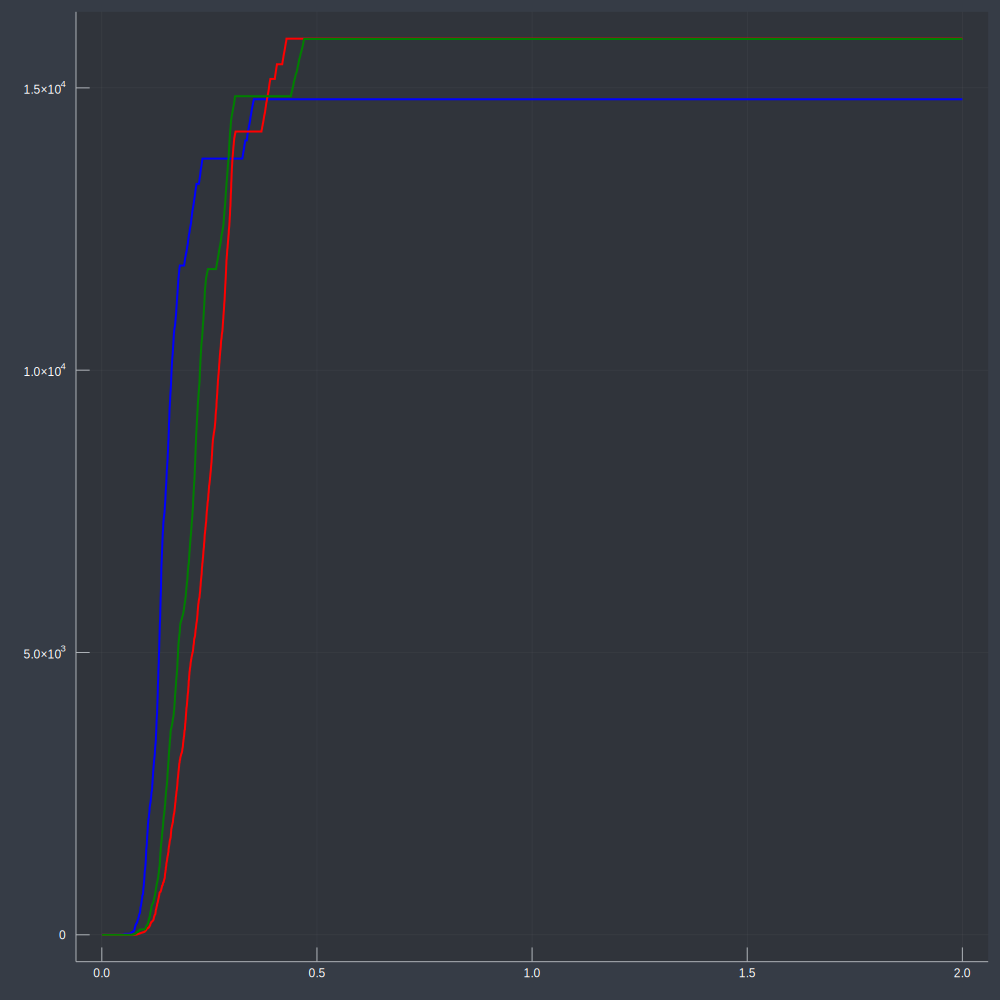

In [35]:
p2a=plot(size=(1000,1000))

edge_weights = sort(unique(Iterators.flatten(data_WT[1,:,:])))
nEdgeWeights = length(edge_weights)
barcode_data = barcode(PH_AS[1],dim=1)
bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false) 
plot!([edge_weights; 2],cumsum(bettiCurve_1,dims=1), c=:blue, linewidth = 2,legend=false)

edge_weights = sort(unique(Iterators.flatten(data_WT[2,:,:])))
nEdgeWeights = length(edge_weights)
barcode_data = barcode(PH_AS[2],dim=1)
bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false) 
plot!([edge_weights; 2],cumsum(bettiCurve_1,dims=1), c=:red, linewidth = 2,legend=false)

edge_weights = sort(unique(Iterators.flatten(data_WT[3,:,:])))
nEdgeWeights = length(edge_weights)
barcode_data = barcode(PH_AS[3],dim=1)
bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false) 
plot!([edge_weights; 2],cumsum(bettiCurve_1,dims=1), c=:green, linewidth = 2,legend=false)

p2a

In [50]:
PH_AS=Array{Any}(undef,size(data_WT)[1],size(data_WT)[2])
for idx_gen in range(1,stop=size(data_WT)[1])
    for idx_fish in range(1,stop=size(data_WT)[2])
        if ~isnan(data_WT[idx_gen,idx_fish,2,3])
            C = eirene(data_WT[idx_gen,idx_fish,:,:], model = "vr", maxdim=3)
            PH_AS[idx_gen,idx_fish]=C
        end
    end
end

In [51]:
WTtoPlot=Array{Float64}(undef,size(data_WT)[1],size(data_WT)[2],3)
for idx_loom in range(1,stop=size(data_WT)[1])    
    for idx_fish in range(1,stop=size(data_WT)[2])
        if ~isnan(data_WT[idx_loom,idx_fish,2,3])
        #print(string(idx_loom) * " fish : " * string(idx_fish))
        edge_weights = sort(unique(Iterators.flatten(data_WT[idx_loom,idx_fish,:,:])))
        nEdgeWeights = length(edge_weights)
        barcode_data = barcode(PH_AS[idx_loom,idx_fish],dim=0)        
        if size(barcode_data)[1]>2
            bettiCurve_1 = bettiCurveFromBarcode(barcode_data[1:end-1,:],nEdgeWeights,edge_weights,false) 
            WTtoPlot[idx_loom,idx_fish,1]=cumsum(bettiCurve_1,dims=1)[end]
            barcode_data = barcode(PH_AS[idx_loom,idx_fish],dim=1)            
            bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
            WTtoPlot[idx_loom,idx_fish,2]=cumsum(bettiCurve_1,dims=1)[end]
            barcode_data = barcode(PH_AS[idx_loom,idx_fish],dim=2)            
            bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
            WTtoPlot[idx_loom,idx_fish,3]=cumsum(bettiCurve_1,dims=1)[end]
        end
            end
    end
    print(idx_loom)
end

123

In [52]:
writedlm( "/mnt/d/Emmanuel/PerFish/AS_full_dim1WT.csv",  WTtoPlot[3,:,2], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/AS_full_dim1FMR.csv",  WTtoPlot[1,:,2], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/AS_full_dim1Het.csv",  WTtoPlot[2,:,2], ',')

In [53]:
writedlm( "/mnt/d/Emmanuel/PerFish/AS_full_dim0WT.csv",  WTtoPlot[3,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/AS_full_dim0FMR.csv",  WTtoPlot[1,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/AS_full_dim0Het.csv",  WTtoPlot[2,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/AS_full_dim2WT.csv",  WTtoPlot[3,:,3], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/AS_full_dim2FMR.csv",  WTtoPlot[1,:,3], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/AS_full_dim2Het.csv",  WTtoPlot[2,:,3], ',')

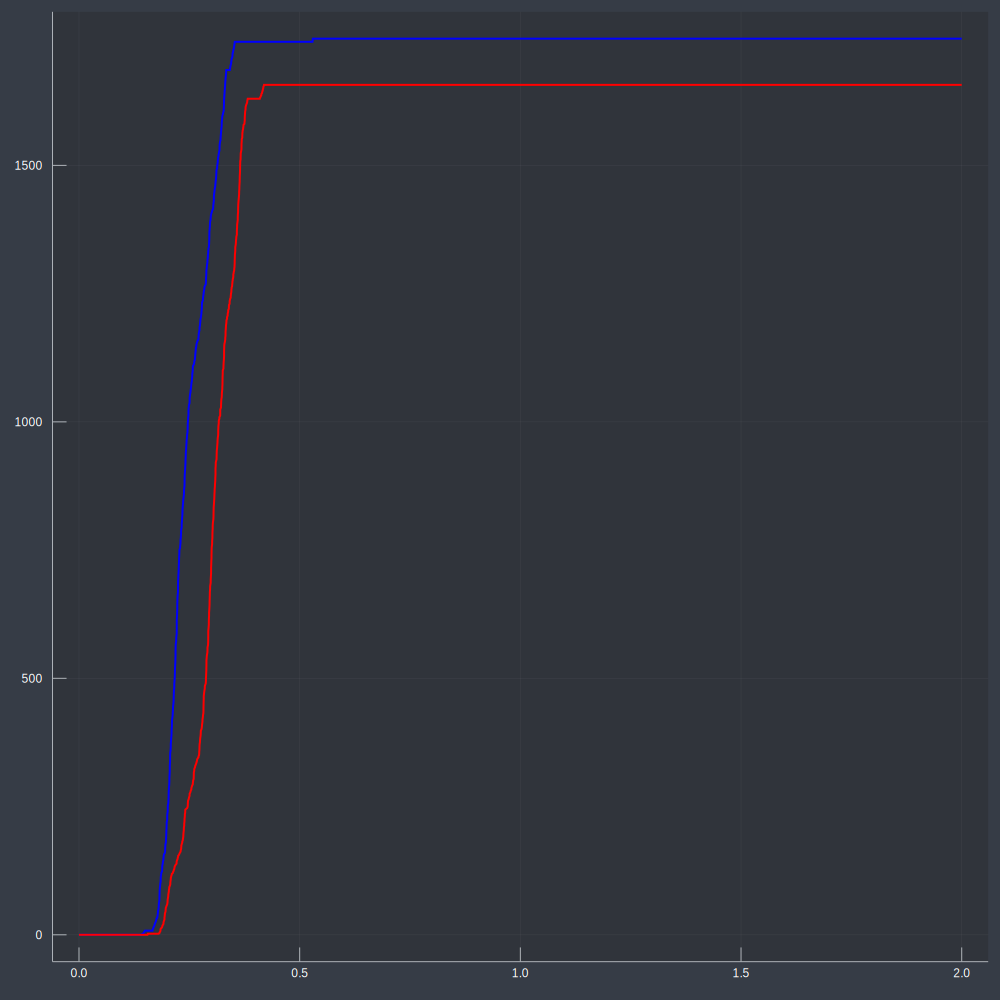

In [41]:
file = matopen("/mnt/d/Emmanuel/PerFish/CorrMatrices_LenaLoom_avg.mat")
data_WT=read(file, "CorrMatrices") # note that this does NOT introduce a variable ``varname`` into scope
close(file)
PH_AS=Array{Any}(undef,3)
for idx_gen in range(1,stop=size(data_WT)[1])
    C = eirene(data_WT[idx_gen,:,:], model = "vr", maxdim=3)
    PH_AS[idx_gen]=C
end
p2a=plot(size=(1000,1000))

edge_weights = sort(unique(Iterators.flatten(data_WT[1,:,:])))
nEdgeWeights = length(edge_weights)
barcode_data = barcode(PH_AS[1],dim=1)
bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false) 
plot!([edge_weights; 2],cumsum(bettiCurve_1,dims=1), c=:blue, linewidth = 2,legend=false)

edge_weights = sort(unique(Iterators.flatten(data_WT[2,:,:])))
nEdgeWeights = length(edge_weights)
barcode_data = barcode(PH_AS[2],dim=1)
bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false) 
plot!([edge_weights; 2],cumsum(bettiCurve_1,dims=1), c=:red, linewidth = 2,legend=false)

p2a

In [44]:
file = matopen("/mnt/d/Emmanuel/PerFish/CorrMatrices_LenaLoom_minusFish.mat")
data_WT=read(file, "CorrMatrices_MinusFish") # note that this does NOT introduce a variable ``varname`` into scope
close(file)
PH_AS=Array{Any}(undef,size(data_WT)[1],size(data_WT)[2])
for idx_gen in range(1,stop=size(data_WT)[1])
    for idx_fish in range(1,stop=size(data_WT)[2])
        if ~isnan(data_WT[idx_gen,idx_fish,2,3])
            C = eirene(data_WT[idx_gen,idx_fish,:,:], model = "vr", maxdim=3)
            PH_AS[idx_gen,idx_fish]=C
        end
    end
end

In [45]:
WTtoPlot=Array{Float64}(undef,size(data_WT)[1],size(data_WT)[2],3)
for idx_loom in range(1,stop=size(data_WT)[1])    
    for idx_fish in range(1,stop=size(data_WT)[2])
        if ~isnan(data_WT[idx_loom,idx_fish,2,3])
        #print(string(idx_loom) * " fish : " * string(idx_fish))
        edge_weights = sort(unique(Iterators.flatten(data_WT[idx_loom,idx_fish,:,:])))
        nEdgeWeights = length(edge_weights)
        barcode_data = barcode(PH_AS[idx_loom,idx_fish],dim=0)        
        if size(barcode_data)[1]>2
            bettiCurve_1 = bettiCurveFromBarcode(barcode_data[1:end-1,:],nEdgeWeights,edge_weights,false) 
            WTtoPlot[idx_loom,idx_fish,1]=cumsum(bettiCurve_1,dims=1)[end]
            barcode_data = barcode(PH_AS[idx_loom,idx_fish],dim=1)            
            bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
            WTtoPlot[idx_loom,idx_fish,2]=cumsum(bettiCurve_1,dims=1)[end]
            barcode_data = barcode(PH_AS[idx_loom,idx_fish],dim=2)            
            bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
            WTtoPlot[idx_loom,idx_fish,3]=cumsum(bettiCurve_1,dims=1)[end]
        end
            end
    end
    print(idx_loom)
end
writedlm( "/mnt/d/Emmanuel/PerFish/LenaLoom_full_dim1WT.csv",  WTtoPlot[1,:,2], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/LenaLoom_full_dim1fmr1.csv",  WTtoPlot[2,:,2], ',')

123

In [47]:
writedlm( "/mnt/d/Emmanuel/PerFish/LenaLoom_full_dim0WT.csv",  WTtoPlot[1,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/LenaLoom_full_dim0fmr1.csv",  WTtoPlot[2,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/LenaLoom_full_dim2WT.csv",  WTtoPlot[1,:,3], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/LenaLoom_full_dim2fmr1.csv",  WTtoPlot[2,:,3], ',')